# Wrangle

In [141]:
# 1. layer: files of size 2140, 1904, 1762, 1857 get merged into a file of size 2514
# 2. layer: the file from the previous step which has the size 2514 gets inner joined with an external file of size 29361 and it results in a file of size 2514
# 3. layer: the file from the previous layer which has the size 2514 gets inner joined with an API and finally has size 1708

import plotly.graph_objects as go
from pathlib import Path

outputpath = Path.cwd().parent / "data" / "assets"

labels = ["Sunshines 2023 (size 2140)", "Sunshines 2022 (size 1904)", "Sunshines 2020 (size 1762)", "Sunshines 2021 (size 1857)", "Sunshines Merged (size 2514)", "CS Rankings (size 29361)", "Sunshines x CS Rankings (size 2514)", "API File (size ≥1708)", "Final File (size 1708)"]

source = [0, 1, 2, 3, 4, 5, 6, 7]
target = [4, 4, 4, 4, 6, 6, 8, 8]
value = [2140, 1904, 1762, 1857, 2514, 29361, 2514, 1708, 1708]

fig = go.Figure(data=[go.Sankey(node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels, color="blue"), link=dict(source=source, target=target, value=value))])

fig.update_layout(title_text="Data Joining Process Sankey Diagram", font_size=10)
fig.show()

# store
filepath = outputpath / "wrangle-sankey"
fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
)

# high res
import plotly.io as pio

pio.kaleido.scope.default_scale = 2
pio.kaleido.scope.default_width = 1200
pio.kaleido.scope.default_height = 800
fig.write_image(str(filepath) + ".png")

# Profile

In [79]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pointbiserialr


datapath = Path.cwd().parent / "data" / "sunshines-v4.csv"
df = pd.read_csv(datapath)

#
# preprocessing
#


def get_latest_totalcomp(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        salary_col = f"salary_{year}"
        benefits_col = f"benefits_{year}"
        if salary_col in row.index and benefits_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[salary_col]) and pd.notna(row[benefits_col]):  # check if both present
                return row[salary_col] + row[benefits_col]  # get total comp
    print(f"warning: {row['name']}")
    return pd.NA


def get_latest_role(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        role_col = f"role_{year}"
        if role_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[role_col]):  # check if present
                return row[role_col]
    print(f"warning: {row['name']}")
    return pd.NA


def get_latest_role_cluster(row):
    years = ["2023", "2022", "2021", "2020"]
    for year in years:
        role_col = f"role_cluster_{year}"
        if role_col in row.index:  # fall back to previous year if current year is missing
            if pd.notna(row[role_col]):  # check if present
                return row[role_col]
    print(f"warning: {row['name']}")
    return pd.NA


df["latest_totalcomp"] = df.apply(get_latest_totalcomp, axis=1)
df["latest_role"] = df.apply(get_latest_role, axis=1)
df["latest_role_cluster"] = df.apply(get_latest_role_cluster, axis=1)
df["perf_combined"] = df["paper_count"] + df["citation_count"] + df["h_index"]
for year in range(2020, 2024):
    df[f"totalcomp_{year}"] = df[f"salary_{year}"] + df[f"benefits_{year}"]

print(df.dtypes)
df.head()

name                    object
sex                     object
paper_count              int64
citation_count           int64
h_index                  int64
role_2020               object
role_cluster_2020      float64
salary_2020            float64
benefits_2020          float64
role_2021               object
role_cluster_2021      float64
salary_2021            float64
benefits_2021          float64
role_2022               object
role_cluster_2022      float64
salary_2022            float64
benefits_2022          float64
role_2023               object
role_cluster_2023      float64
salary_2023            float64
benefits_2023          float64
latest_totalcomp       float64
latest_role             object
latest_role_cluster    float64
perf_combined            int64
totalcomp_2020         float64
totalcomp_2021         float64
totalcomp_2022         float64
totalcomp_2023         float64
dtype: object


,name,sex,paper_count,citation_count,h_index,role_2020,role_cluster_2020,salary_2020,benefits_2020,role_2021,...,salary_2023,benefits_2023,latest_totalcomp,latest_role,latest_role_cluster,perf_combined,totalcomp_2020,totalcomp_2021,totalcomp_2022,totalcomp_2023
0,Yousra Aafer,F,34,2998,18,Assistant Professor,3.0,148935.04,158.96,Assistant Professor,...,160442.56,276.08,160718.64,Assistant Professor,3.0,3050,149094.00,154313.40,159488.20,160718.64
1,Eihab Abdel-rahman,M,197,5193,31,Professor,3.0,195256.60,215.48,Professor,...,221699.84,370.76,222070.60,Professor,3.0,5421,195472.08,206567.72,210558.60,222070.60
2,Ishan S. Abeywardena,M,37,144,6,Associate Director Systems,19.0,125246.72,334.00,Associate Director Systems,...,142080.64,550.72,142631.36,Associate Director Systems,19.0,187,125580.72,130435.29,134382.97,142631.36
3,Hossein Abouee Mehrizi,M,31,450,13,Associate Professor,3.0,175698.40,293.66,Associate Professor,...,209521.60,755.32,210276.92,Professor,3.0,494,175992.06,208375.44,207523.76,210276.92
4,John Abraham,M,383,9432,47,NaN,NaN,NaN,NaN,Continuing Lecturer and Manager of Internation...,...,134059.52,875.24,134934.76,Academic Dean Continuing Lecturer and Manager ...,10.0,9862,NaN,105171.84,115881.00,134934.76


In [80]:
#
# simple questions
#

print(f"number of total roles: {df['latest_role'].nunique()}")
print(f"highest total comp: {df['latest_totalcomp'].max()}")
print(f"lowest total comp: {df['latest_totalcomp'].min()}")
print(f"average total comp: {df['latest_totalcomp'].mean()}")
print(f"median total comp: {df['latest_totalcomp'].median()}")
print(f"highest paying role: {df[df['latest_totalcomp'] == df['latest_totalcomp'].max()]['latest_role'].values[0]} with {df['latest_totalcomp'].max()}")
print()

number of total roles: 396
highest total comp: 496699.64999999997
lowest total comp: 100174.6
average total comp: 167443.05435011708
median total comp: 160719.46000000002
highest paying role: President with 496699.64999999997



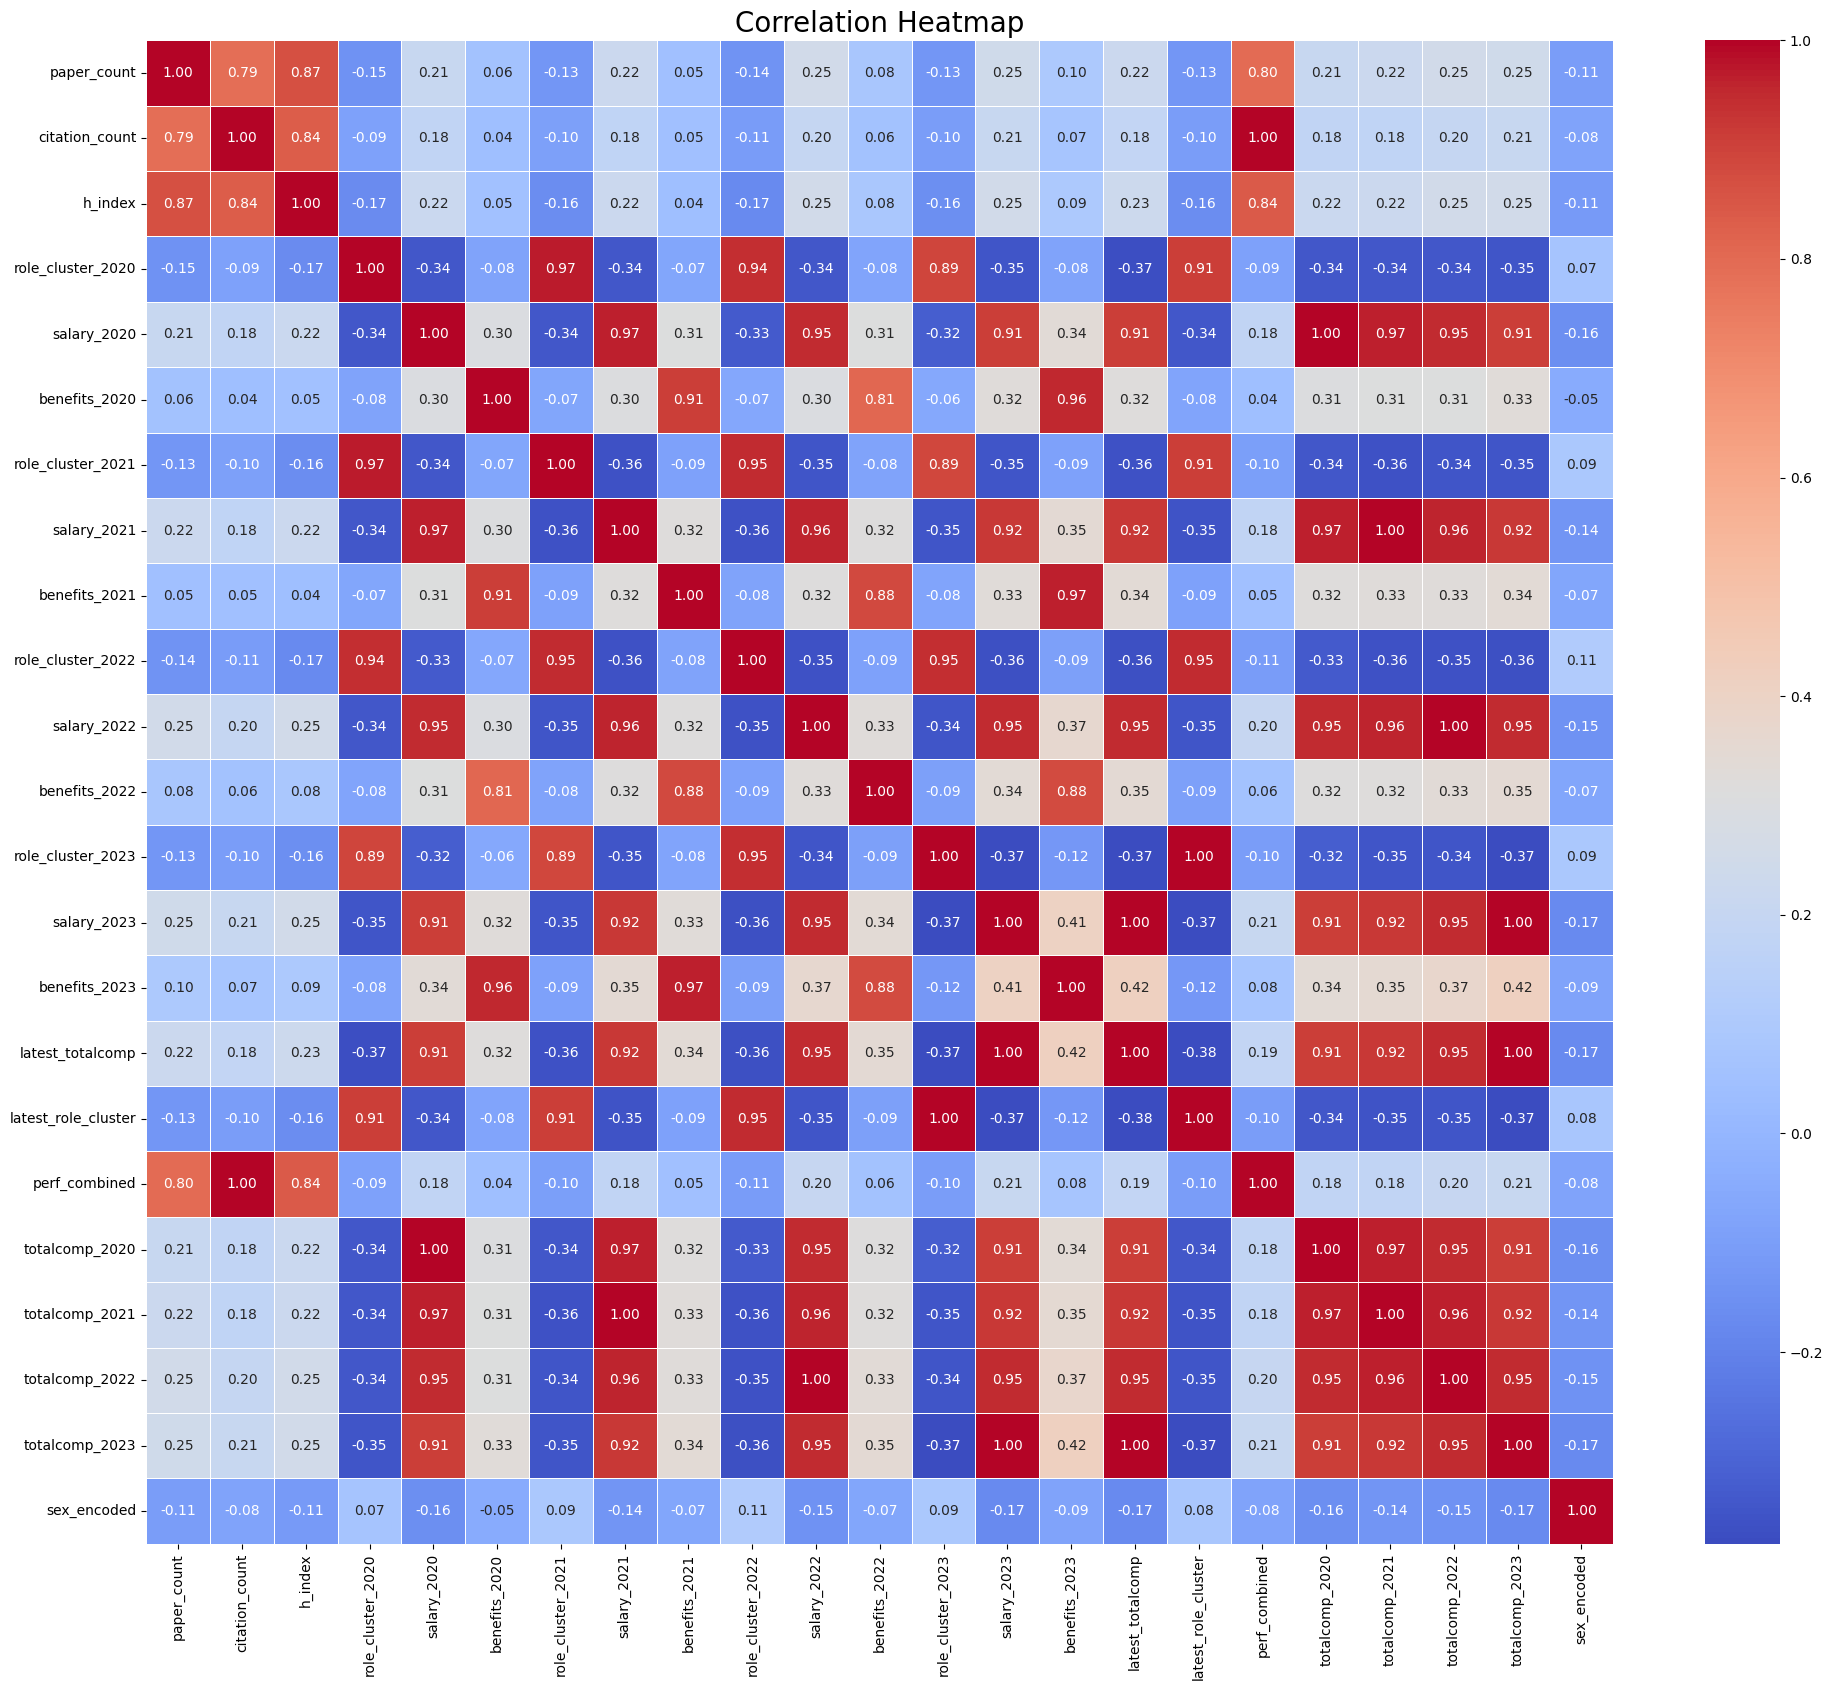

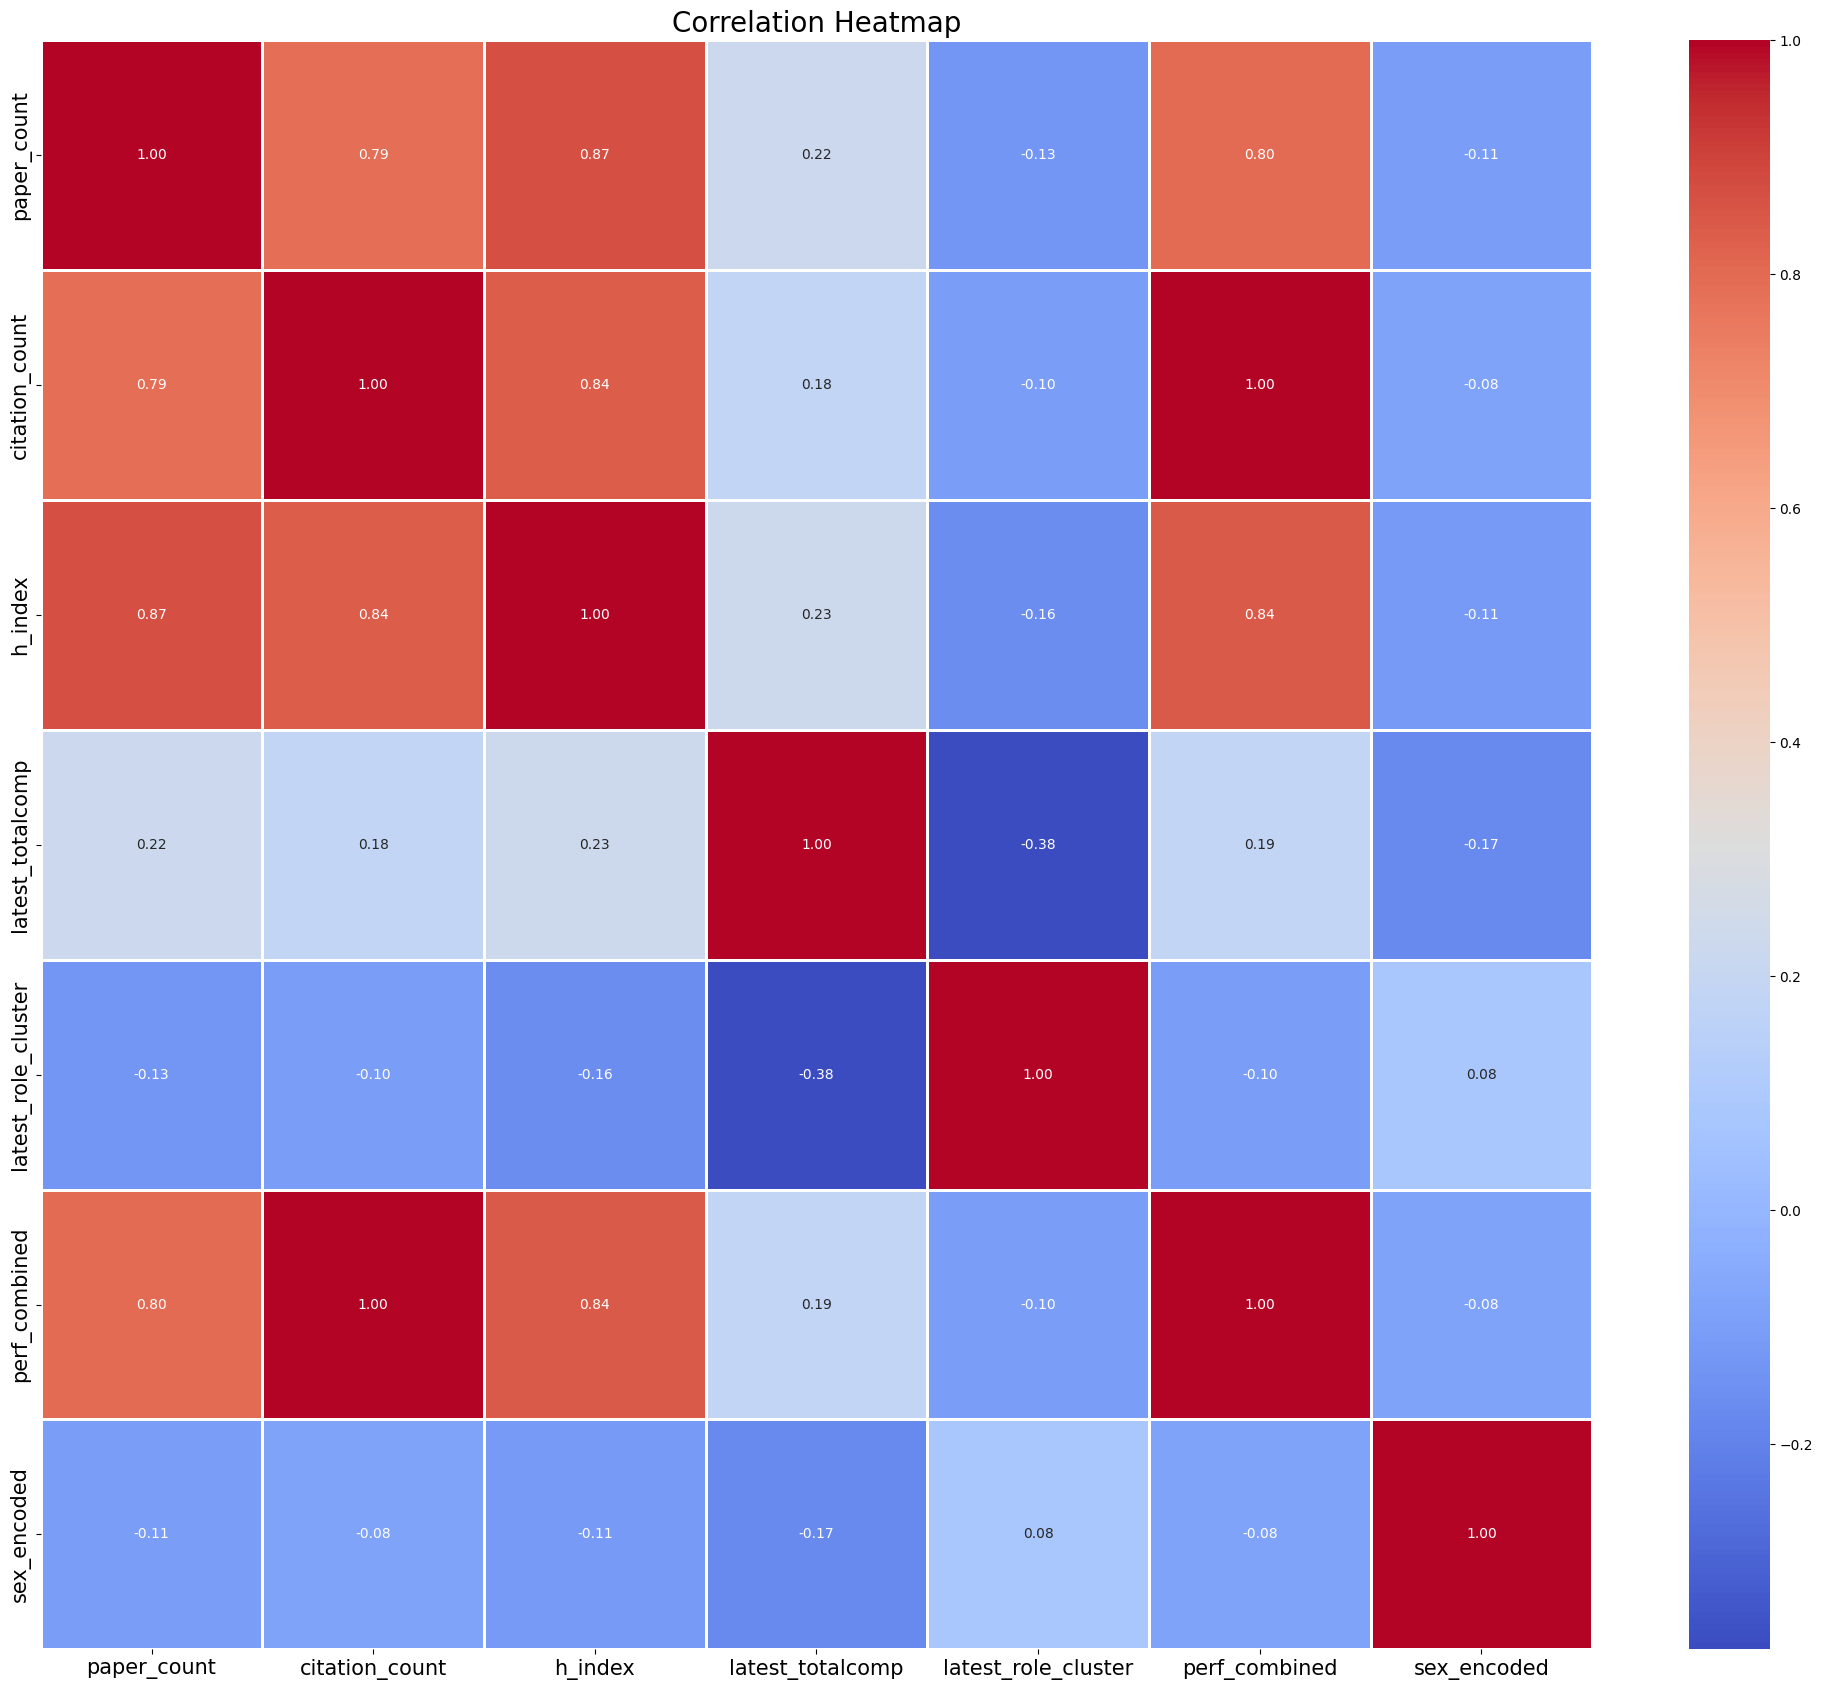

In [81]:
#
# heatmap v1
#

df["sex_encoded"] = df["sex"].map({"M": 1, "F": 2, None: 0})  # encode_sex
numeric_df = df.select_dtypes(include=["float64", "int64"])
numeric_df["sex_encoded"] = df["sex_encoded"]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=20)
plt.tight_layout()
plt.show()


#
# heatmap v2
#
# conclusion: role and comp correlate, but not role and perf
#

df["sex_encoded"] = df["sex"].map({"M": 1, "F": 2, None: 0})  # encode_sex
numeric_df = df.select_dtypes(include=["float64", "int64"])
numeric_df["sex_encoded"] = df["sex_encoded"]

numeric_df = numeric_df.drop(
    columns=[
        "role_cluster_2020",
        "salary_2020",
        "benefits_2020",
        "role_cluster_2021",
        "salary_2021",
        "benefits_2021",
        "role_cluster_2022",
        "salary_2022",
        "benefits_2022",
        "role_cluster_2023",
        "salary_2023",
        "benefits_2023",
        "totalcomp_2020",
        "totalcomp_2021",
        "totalcomp_2022",
        "totalcomp_2023",
    ]
)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Correlation Heatmap", fontsize=20)
plt.tight_layout()
plt.show()

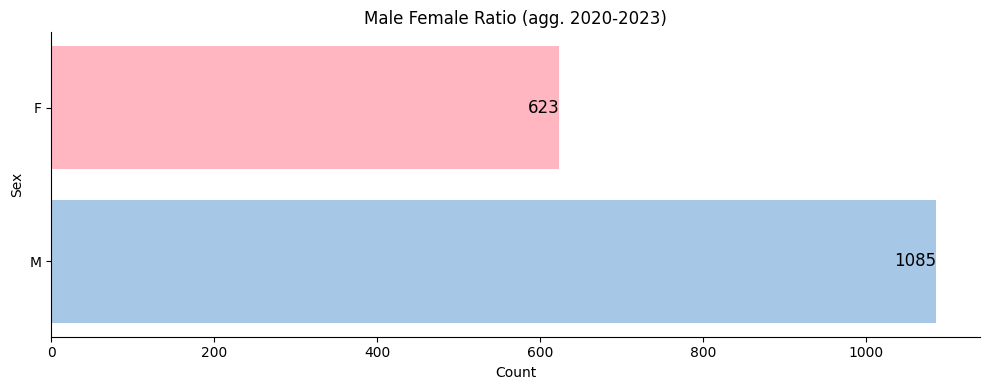

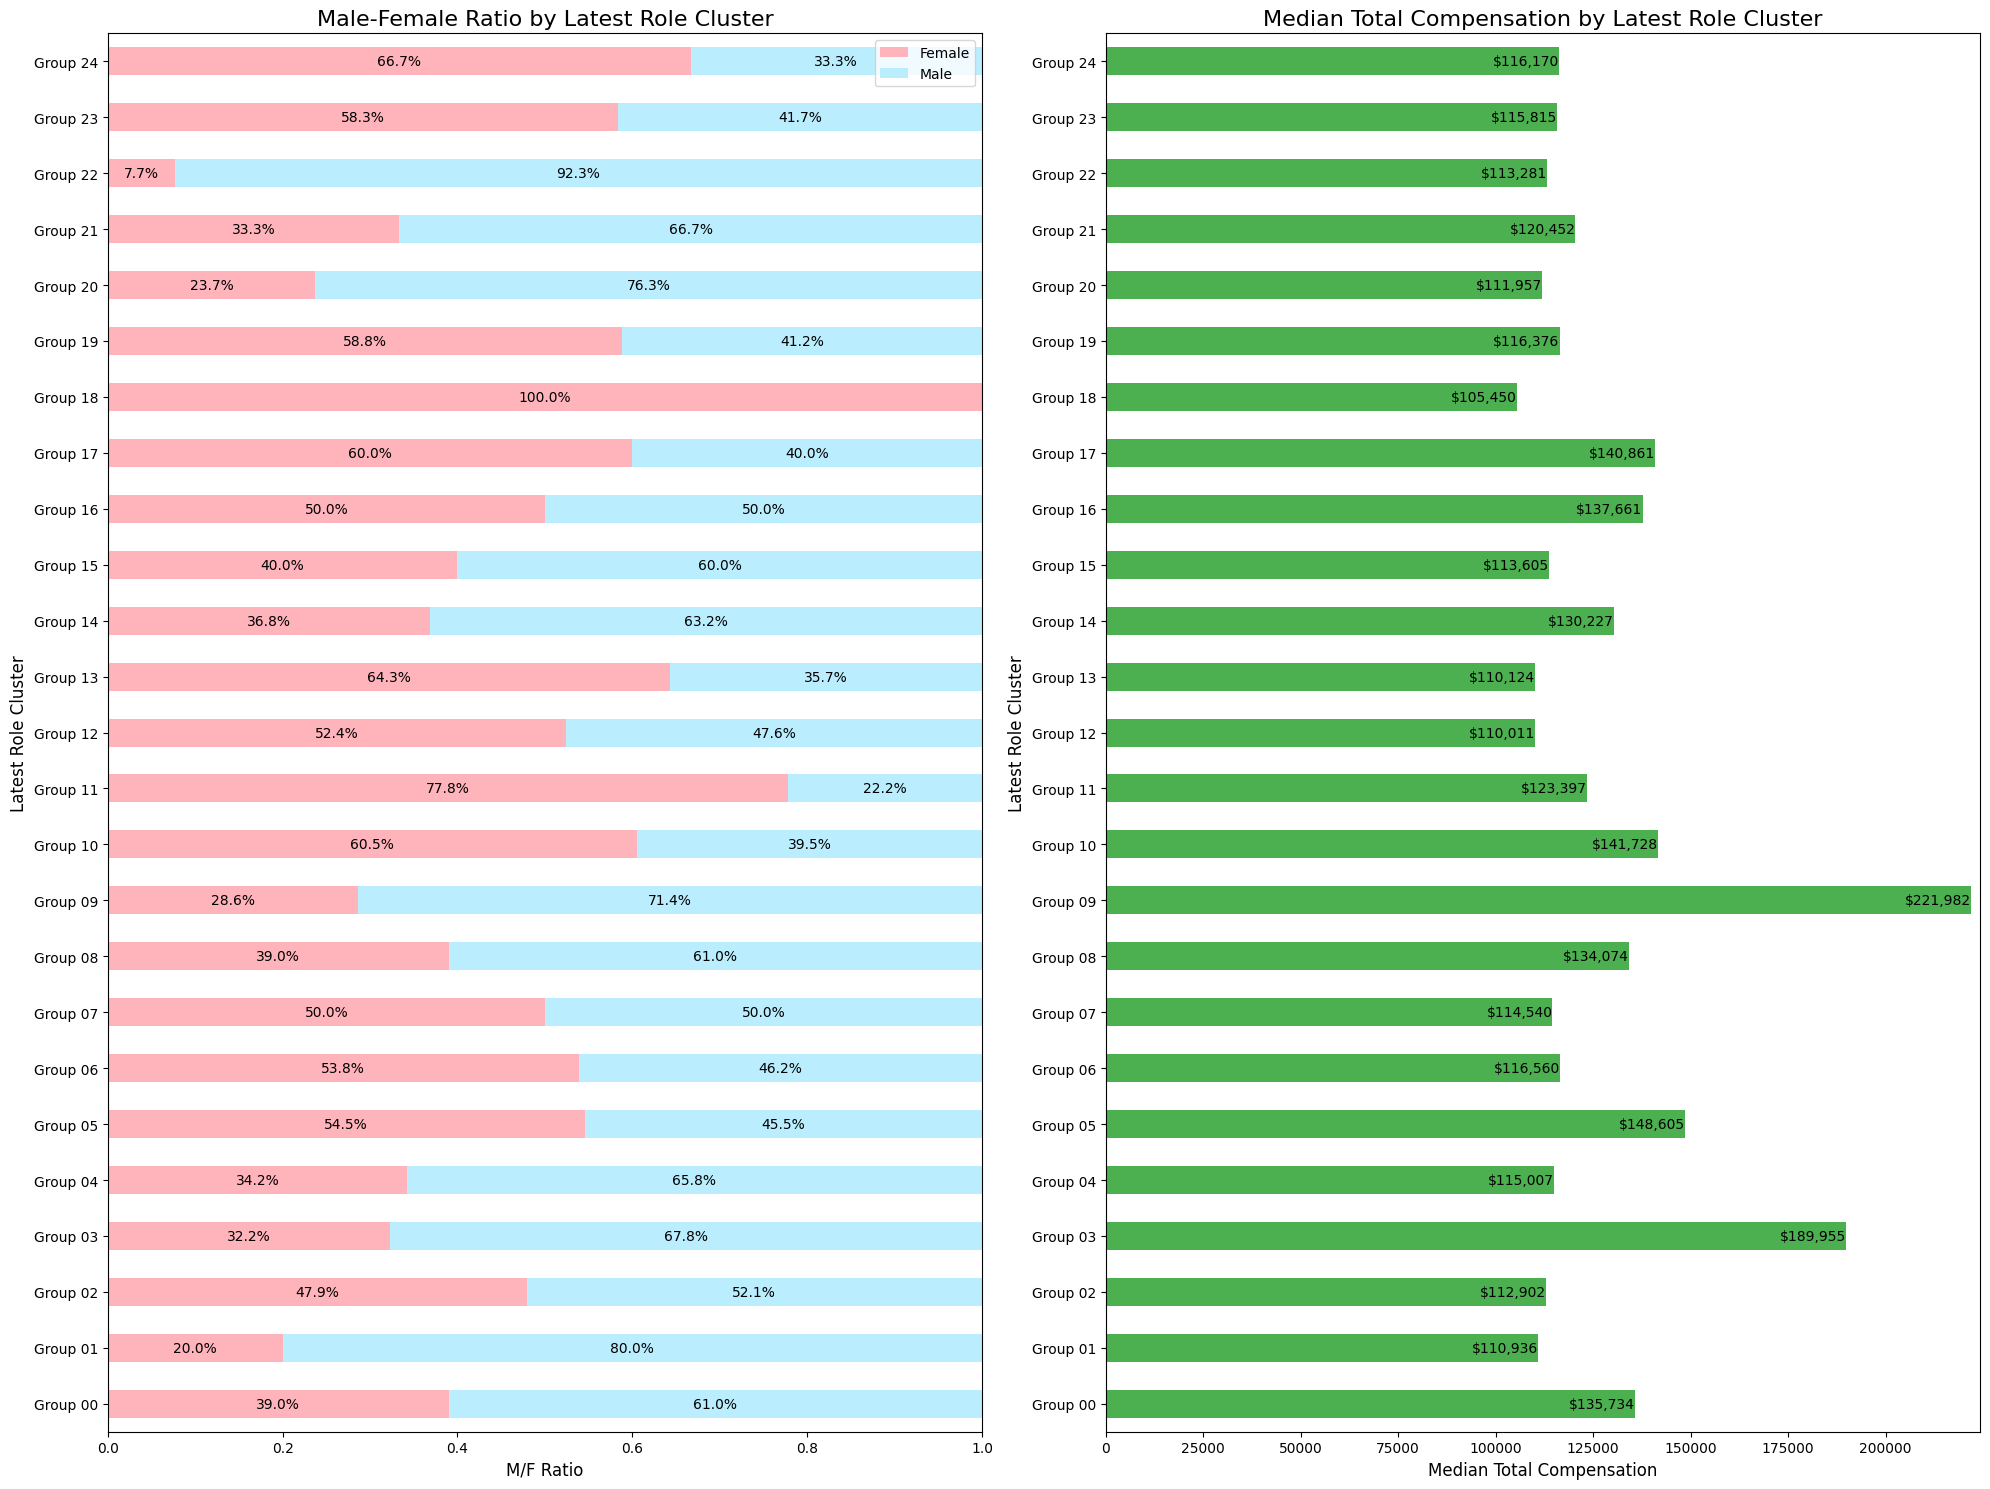

In [121]:
#
# m/f ratio
#
# this is used just for the tuned model: https://huggingface.co/distilbert/distilbert-base-uncased
#
# https://www.researchgate.net/figure/The-DistilBERT-model-architecture-and-components_fig2_358239462
#

sex_counts = df["sex"].value_counts(dropna=False)

fig, ax = plt.subplots(figsize=(10, 4))
pastel_blue = "#A7C7E7"
pastel_pink = "#FFB6C1"
colors = [pastel_blue, pastel_pink, "lightgray"]
bars = ax.barh(sex_counts.index, sex_counts.values, color=colors)

ax.set_xlabel("Count")
ax.set_ylabel("Sex")
ax.set_title("Male Female Ratio (agg. 2020-2023)")

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f"{width}", ha="right", va="center", fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

#
# role, money, gender bar charts
#

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# ---------- plot1

plot_df = df[df["sex"].isin(["M", "F"]) & df["latest_role_cluster"].notna()]
gender_ratio = plot_df.groupby("latest_role_cluster")["sex"].value_counts(normalize=True).unstack()
gender_ratio = gender_ratio.fillna(0)
# gender_ratio = gender_ratio.sort_values('F', ascending=False) # sort by F in descending order

gender_ratio.plot(kind="barh", stacked=True, color=["#FFB3BA", "#BAEEFF"], ax=ax1)

ax1.set_title("Male-Female Ratio by Latest Role Cluster", fontsize=16)
ax1.set_xlabel("M/F Ratio", fontsize=12)
ax1.set_ylabel("Latest Role Cluster", fontsize=12)
ax1.legend(labels=["Female", "Male"], loc="upper right")
ax1.set_xlim(0, 1)

yticks = [f"Group {int(i):02d}" for i in gender_ratio.index]
ax1.set_yticks(range(len(yticks)))
ax1.set_yticklabels(yticks)

for i, row in enumerate(gender_ratio.itertuples()):
    female_pct = row.F if not np.isnan(row.F) else 0
    male_pct = row.M if not np.isnan(row.M) else 0
    if female_pct > 0:
        ax1.text(female_pct / 2, i, f"{female_pct:.1%}", va="center", ha="center", color="black")
    if male_pct > 0:
        ax1.text(female_pct + male_pct / 2, i, f"{male_pct:.1%}", va="center", ha="center", color="black")

# ---------- plot1

plot_df = df[df["latest_totalcomp"].notna() & df["latest_role_cluster"].notna()]
med_comp = plot_df.groupby("latest_role_cluster")["latest_totalcomp"].median()
# med_comp = med_comp.sort_values(ascending=False)

med_comp.plot(kind="barh", color="#4CAF50", ax=ax2)

ax2.set_title("Median Total Compensation by Latest Role Cluster", fontsize=16)
ax2.set_xlabel("Median Total Compensation", fontsize=12)
ax2.set_ylabel("Latest Role Cluster", fontsize=12)
ax2.set_xlim(0, med_comp.max() * 1.01)

yticks = [f"Group {int(i):02d}" for i in med_comp.index]
ax2.set_yticks(range(len(yticks)))
ax2.set_yticklabels(yticks)

for i, value in enumerate(med_comp):
    ax2.text(value, i, f"${value:,.0f}", va="center", ha="right", color="black")

plt.tight_layout()
plt.show()

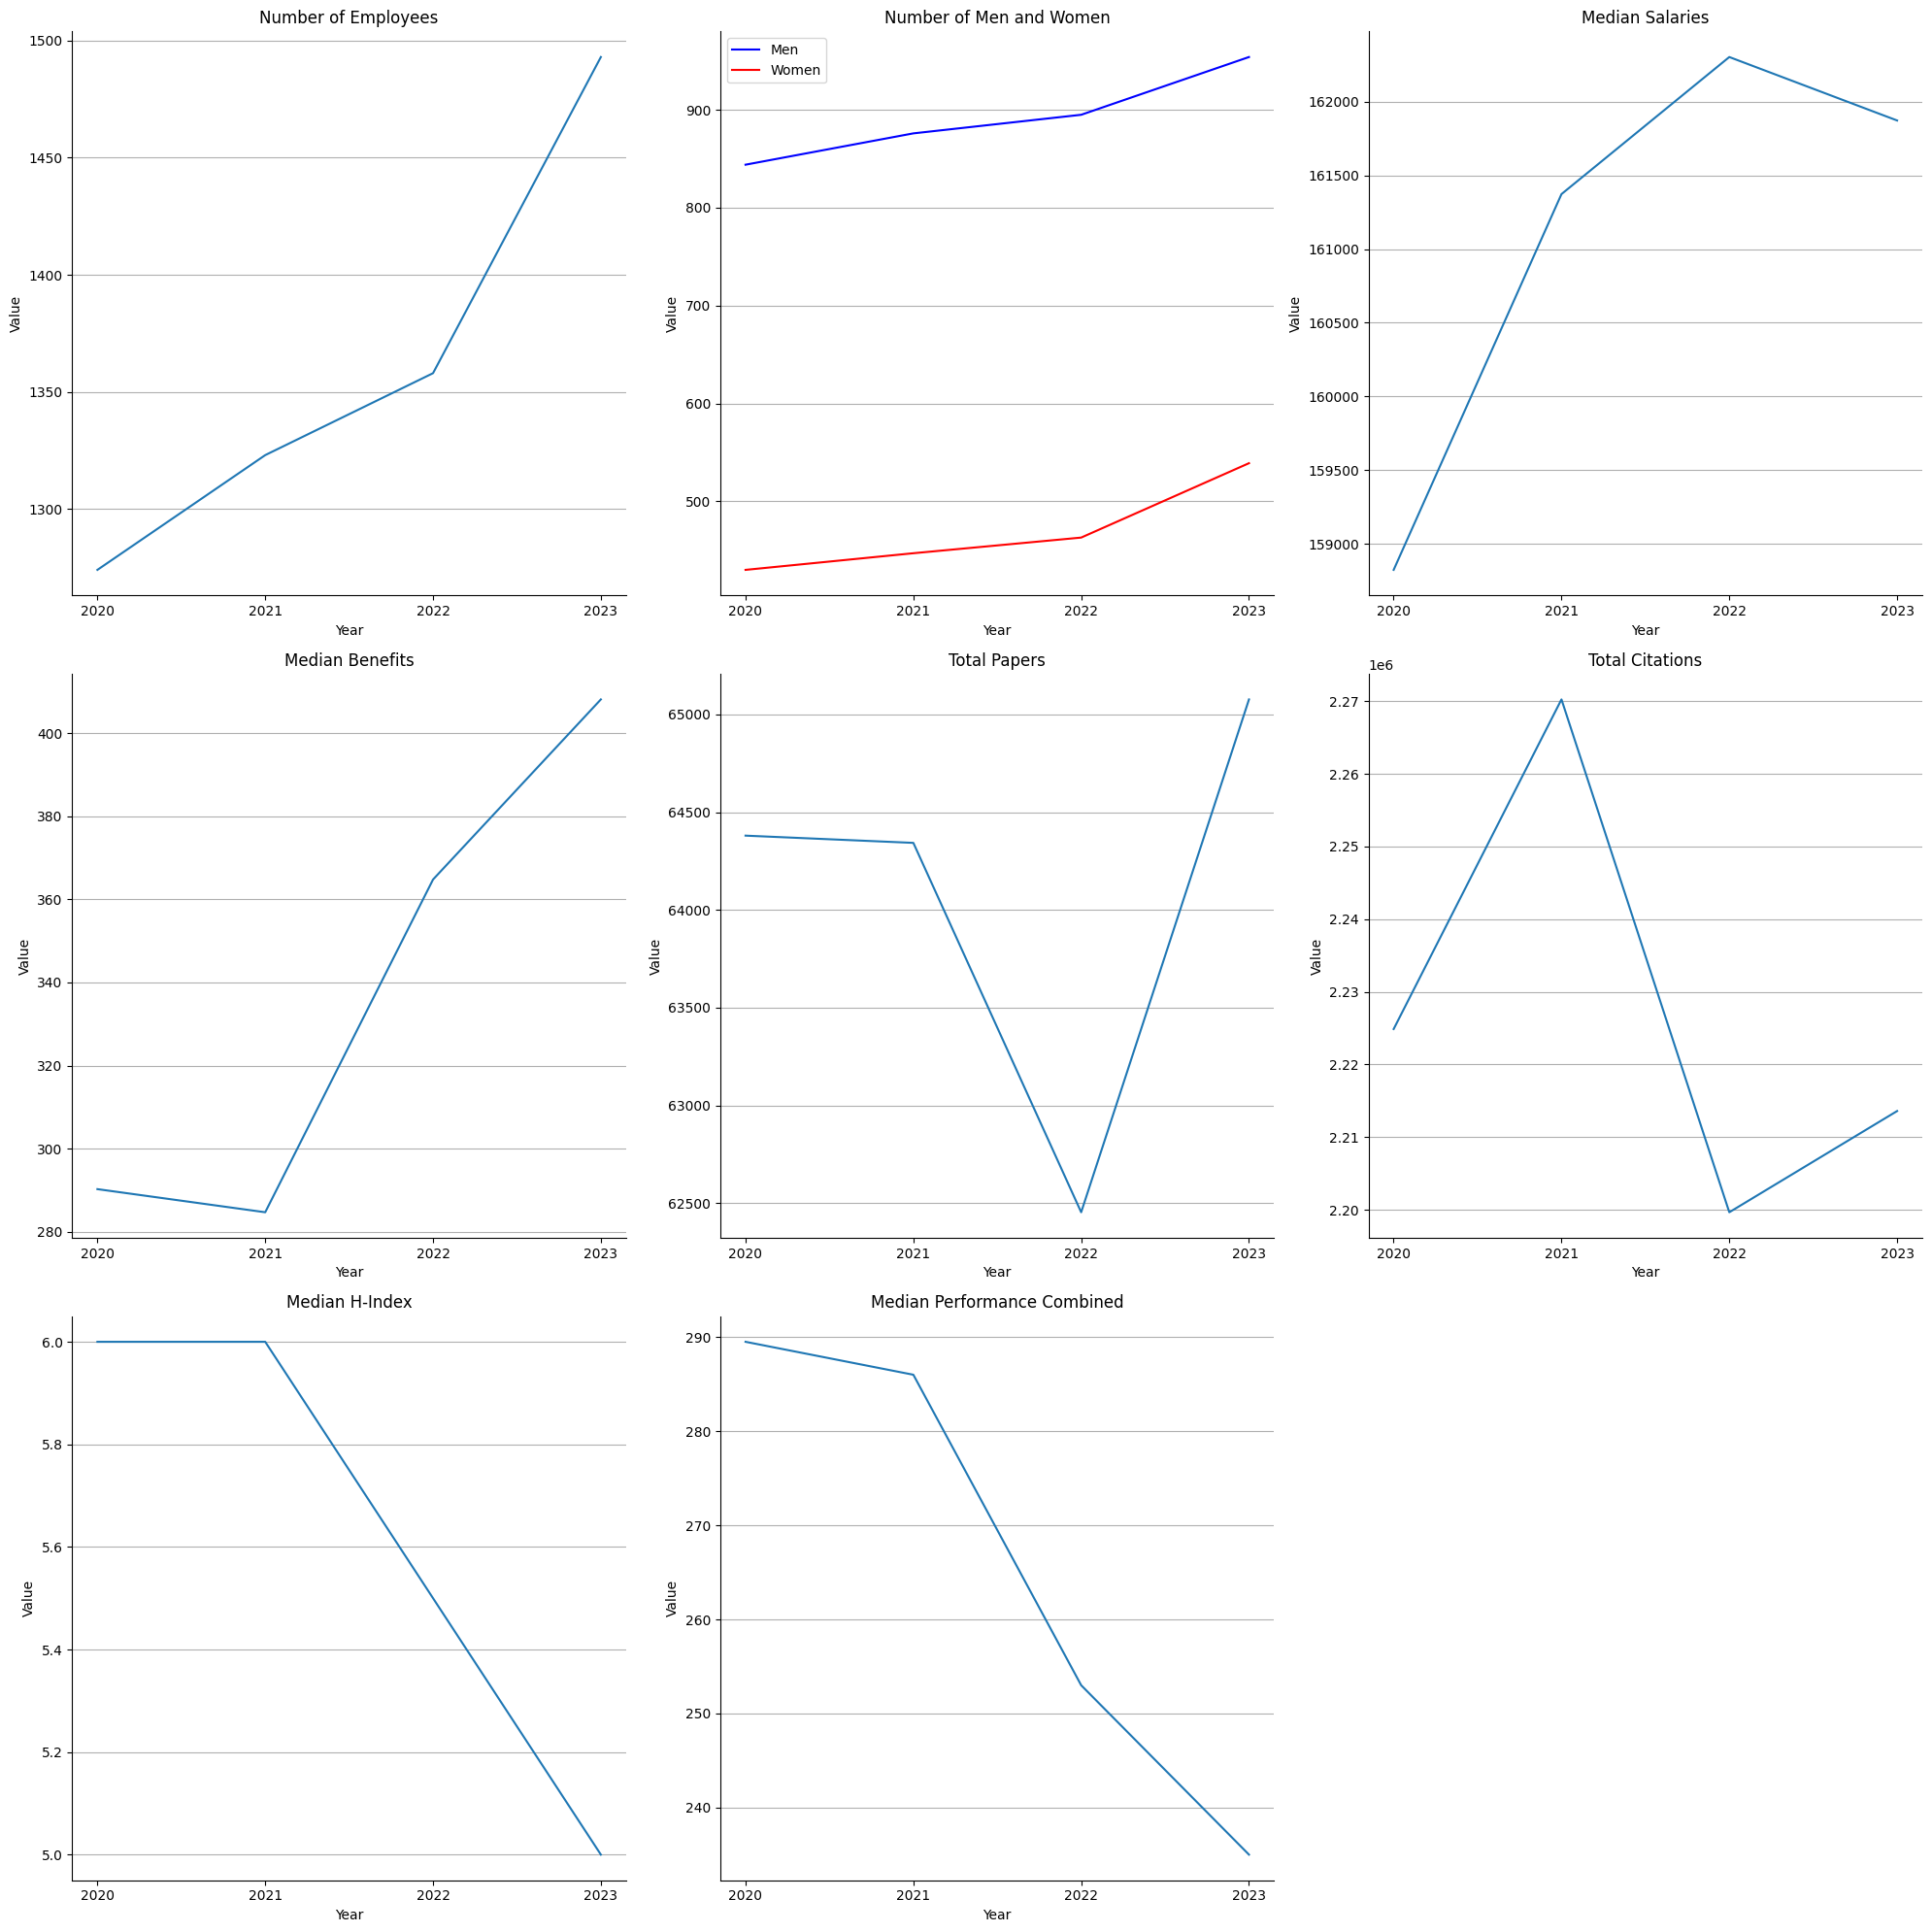

In [140]:
#
# time series data
#

years = range(2020, 2024)
num_employees = []
num_men = []
num_women = []
med_salaries = []
med_benefits = []
total_papers = []
total_citations = []
med_hindex = []
med_perfcombined = []

for year in years:
    year_df = df[df[f"role_{year}"].notna()]
    num_employees.append(len(year_df))
    num_men.append(len(year_df[year_df["sex"] == "M"]))
    num_women.append(len(year_df[year_df["sex"] == "F"]))
    med_salaries.append(year_df[f"salary_{year}"].median())
    med_benefits.append(year_df[f"benefits_{year}"].median())
    total_papers.append(year_df["paper_count"].sum())
    total_citations.append(year_df["citation_count"].sum())
    med_hindex.append(year_df["h_index"].median())
    med_perfcombined.append(year_df["perf_combined"].median())

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

axs[0, 0].plot(years, num_employees)
axs[0, 0].set_title("Number of Employees")

axs[0, 1].plot(years, num_men, label="Men", color="blue")
axs[0, 1].plot(years, num_women, label="Women", color="red")
axs[0, 1].set_title("Number of Men and Women")
axs[0, 1].legend()

axs[0, 2].plot(years, med_salaries)
axs[0, 2].set_title("Median Salaries")

axs[1, 0].plot(years, med_benefits)
axs[1, 0].set_title("Median Benefits")

axs[1, 1].plot(years, total_papers)
axs[1, 1].set_title("Total Papers")

axs[1, 2].plot(years, total_citations)
axs[1, 2].set_title("Total Citations")

axs[2, 0].plot(years, med_hindex)
axs[2, 0].set_title("Median H-Index")

axs[2, 1].plot(years, med_perfcombined)
axs[2, 1].set_title("Median Performance Combined")

for i in range(3):
    for j in range(3):
        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

fig.delaxes(axs[2, 2])  # drop empty subplot

for ax in axs.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
    ax.grid(axis="y")

plt.tight_layout()
plt.show()

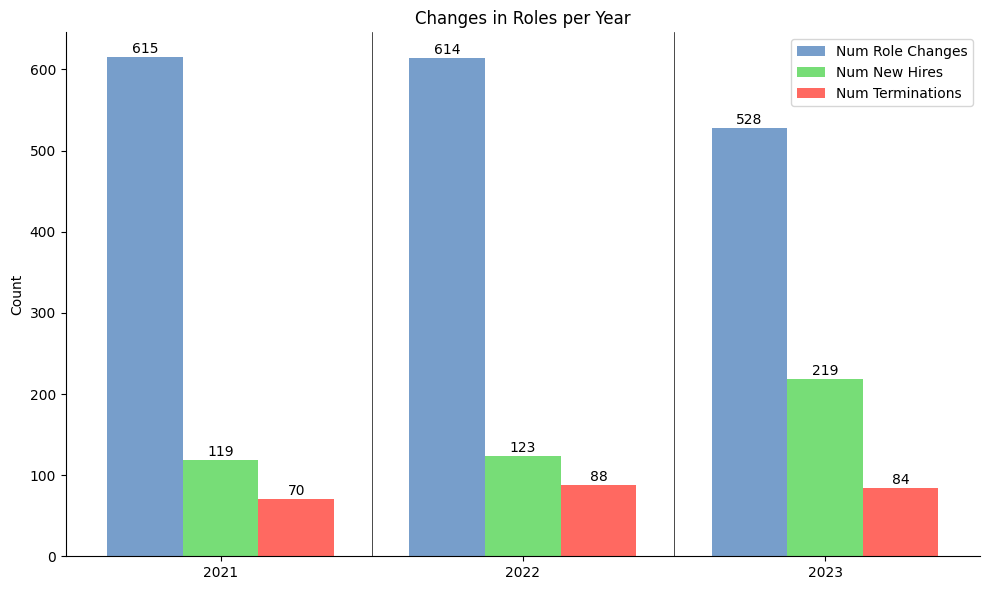

In [122]:
#
# changes in roles per year
#


def count_changes(df, year):
    prev_year = str(int(year) - 1)
    current_col = f"role_{year}"
    prev_col = f"role_{prev_year}"

    changes = (df[current_col] != df[prev_col]).sum()
    hires = ((df[prev_col].isna()) & (df[current_col].notna())).sum()
    fires = ((df[prev_col].notna()) & (df[current_col].isna())).sum()

    return changes, hires, fires


years = ["2021", "2022", "2023"]  # have to skip 2020 since there is no previous year
data = {year: count_changes(df, year) for year in years}

changes = [data[year][0] for year in years]
hires = [data[year][1] for year in years]
fires = [data[year][2] for year in years]

fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(years))
width = 0.25

ax.bar([i - width for i in x], changes, width, label="Num Role Changes", color="#779ECB")
ax.bar(x, hires, width, label="Num New Hires", color="#77DD77")
ax.bar([i + width for i in x], fires, width, label="Num Terminations", color="#FF6961")

for i, v in enumerate(changes):
    ax.text(i - width, v + 5, str(v), color="black", ha="center")
for i, v in enumerate(hires):
    ax.text(i, v + 5, str(v), color="black", ha="center")
for i, v in enumerate(fires):
    ax.text(i + width, v + 5, str(v), color="black", ha="center")

ax.set_ylabel("Count")
ax.set_title("Changes in Roles per Year")
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i in range(1, len(years)):
    ax.axvline(i - 0.5, color="black", lw=0.5)

plt.tight_layout()
plt.show()